In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import zipfile
import os

# Define paths
zip_path = "/content/drive/MyDrive/SARD.zip"  # path to your uploaded zip in Drive
extract_path = "/content/SARD"

# Make sure directory is clean
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Zip extracted to:", extract_path)

Zip extracted to: /content/SARD


In [ ]:
base_path = "/content/SARD/SARD/search-and-rescue-2"
splits = ['train', 'valid', 'test']

for split in splits:
    img_dir = os.path.join(base_path, 'images', split)
    label_dir = os.path.join(base_path, 'labels', split)

    num_images = len(os.listdir(img_dir)) if os.path.exists(img_dir) else 0
    num_labels = len(os.listdir(label_dir)) if os.path.exists(label_dir) else 0

    print(f"{split.upper()}: {num_images} images, {num_labels} labels")

TRAIN: 5427 images, 5427 labels
VALID: 1540 images, 1540 labels
TEST: 769 images, 768 labels


In [ ]:
import os
import shutil
import yaml
from ultralytics import YOLO
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image as PILImage
from IPython.display import display, Image, FileLink

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name()}")

DATASET_PATH = '/content/SARD/SARD/search-and-rescue-2'
IMAGES_PATH = os.path.join(DATASET_PATH, 'images')
LABELS_PATH = os.path.join(DATASET_PATH, 'labels')
OUTPUT_DIR = '/content/SARD/search-and-rescue-2'

os.makedirs(OUTPUT_DIR, exist_ok=True)

GPU Available: True
GPU Device: Tesla T4


In [ ]:
dataset_config = {
    'path': DATASET_PATH,
    'train': os.path.join('images', 'train'),
    'val': os.path.join('images', 'valid'),
    'names': {0: 'person'}
}
with open('data.yaml', 'w') as f:
    yaml.dump(dataset_config, f)

In [ ]:
# Change this value to 'n', 's', 'm', 'l', or 'x' to train different variants
MODEL_VARIANT = 'n'  # Default is nano; modify this to train other variants

best_model_path = os.path.join(OUTPUT_DIR, f'best_sar_model_v10_{MODEL_VARIANT}.pt')
model = YOLO(f'yolov10{MODEL_VARIANT}.pt')

train_or_load = input(f"Do you want to train or load for YOLOv10{MODEL_VARIANT}? (train/load): ").strip().lower()

# Set batch size based on model variant
batch_size = 16
# if MODEL_VARIANT in ['n', 's'] else 8 if MODEL_VARIANT == 'm' else 4

if train_or_load == 'train' or not os.path.exists(best_model_path):
    print(f"Training YOLOv10{MODEL_VARIANT} model...")
    training_args = {
        'data': 'data.yaml',
        'epochs': 100,
        'imgsz': 640,
        'batch': batch_size,
        'patience': 20,
        'optimizer': 'Adam',
        'lr0': 0.001,
        'weight_decay': 0.0005,
        'device': 0 if torch.cuda.is_available() else 'cpu',
        'project': 'search_and_rescue',
        'name': f'yolov10_sar_detection_{MODEL_VARIANT}',
        'exist_ok': True,
        'pretrained': True,
        'amp': True,
        'cache': True,
        'close_mosaic': 10,
        'augment': True,
        'mixup': 0.1,
        'copy_paste': 0.1,
    }
    results = model.train(**training_args)

    final_model_path = os.path.join('search_and_rescue', f'yolov10_sar_detection_{MODEL_VARIANT}', 'weights', 'best.pt')
    if os.path.exists(final_model_path):
        shutil.copy(final_model_path, best_model_path)
        print(f"Best model saved to: {best_model_path}")
    else:
        print(f"Warning: Best model not found at {final_model_path}")
else:
    print(f"Loading pre-trained model from: {best_model_path}")
    model = YOLO(best_model_path)

val_results = model.val(data='data.yaml')
metrics = {
    'variant': MODEL_VARIANT,
    'mAP50': val_results.box.map50,
    'mAP': val_results.box.map,
    'precision': val_results.box.p[0],
    'recall': val_results.box.r[0],
    'model_path': best_model_path
}

# Print metrics for the current variant
print(f"\nPerformance Metrics for YOLOv10{MODEL_VARIANT}:")
print(f"mAP@0.5: {metrics['mAP50']:.3f}")
print(f"mAP@0.5:0.95: {metrics['mAP']:.3f}")
print(f"Precision: {metrics['precision']:.3f}")
print(f"Recall: {metrics['recall']:.3f}")

100%|██████████| 5.59M/5.59M [00:00<00:00, 18.1MB/s]


Training YOLOv10n model...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov10_sar_detection_n, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=20, perspective=0.0, plots=True,

100%|██████████| 755k/755k [00:00<00:00, 3.78MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

YOLOv10n summary: 223 layers, 2,709,380 parameters, 2,709,364 gradients, 8.4 GFLOPs

Transferred 493/595 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 18.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2784.8±1325.3 MB/s, size: 316.9 KB)


train: Scanning /content/SARD/SARD/search-and-rescue-2/labels/train... 5427 images, 573 backgrounds, 0 corrupt: 100%|██████████| 5427/5427 [00:03<00:00, 1694.15it/s]


train: New cache created: /content/SARD/SARD/search-and-rescue-2/labels/train.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (5.5GB RAM): 100%|██████████| 5427/5427 [00:07<00:00, 709.10it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 889.3±478.0 MB/s, size: 341.7 KB)


val: Scanning /content/SARD/SARD/search-and-rescue-2/labels/valid... 1540 images, 179 backgrounds, 0 corrupt: 100%|██████████| 1540/1540 [00:01<00:00, 1397.92it/s]


val: New cache created: /content/SARD/SARD/search-and-rescue-2/labels/valid.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (1.6GB RAM): 100%|██████████| 1540/1540 [00:02<00:00, 681.91it/s] 


Plotting labels to search_and_rescue/yolov10_sar_detection_n/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to search_and_rescue/yolov10_sar_detection_n
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.84G       4.17      5.431      2.656          4        640: 100%|██████████| 340/340 [01:12<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:09<00:00,  5.05it/s]


                   all       1540       2775      0.215      0.287       0.17     0.0709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.34G      4.086       4.16      2.622          7        640: 100%|██████████| 340/340 [01:10<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.77it/s]

                   all       1540       2775      0.268      0.327      0.245     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.35G      4.071      4.023      2.608          8        640: 100%|██████████| 340/340 [01:08<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.66it/s]

                   all       1540       2775      0.277      0.352      0.267      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.37G      4.019      3.815      2.586          5        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.288      0.368      0.271      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.39G      3.925      3.663      2.545          7        640: 100%|██████████| 340/340 [01:08<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.63it/s]

                   all       1540       2775       0.33      0.402      0.316      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       3.4G      3.882      3.544      2.512          6        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]

                   all       1540       2775      0.411      0.403      0.331       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.42G      3.831      3.397      2.484         14        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.69it/s]

                   all       1540       2775      0.422      0.416       0.36       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.43G      3.788      3.322      2.473         15        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]

                   all       1540       2775       0.41      0.435      0.395      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.45G      3.758      3.277      2.454         12        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]

                   all       1540       2775      0.353      0.465      0.398        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.46G      3.715      3.216      2.439          8        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]

                   all       1540       2775      0.433      0.503      0.438      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.47G      3.672      3.133      2.416          8        640: 100%|██████████| 340/340 [01:08<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]

                   all       1540       2775      0.469      0.451      0.437      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.49G      3.678      3.096      2.423          7        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]

                   all       1540       2775      0.459      0.494      0.442      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.51G      3.629      2.992      2.394         14        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]

                   all       1540       2775      0.507      0.485      0.482      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.52G       3.63       3.03      2.389         13        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.475      0.502      0.476      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.54G        3.6      2.922      2.369          6        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.524      0.487      0.491      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.55G       3.56      2.893       2.36          6        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.485      0.522      0.497      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.57G      3.519      2.855      2.351          9        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.69it/s]

                   all       1540       2775      0.508       0.49      0.495       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.59G      3.512      2.836      2.357         10        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]

                   all       1540       2775      0.536       0.53       0.53      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       3.6G      3.486      2.763      2.348         13        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.538      0.531      0.527      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.62G      3.498      2.809      2.348          6        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.528      0.535      0.543      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.63G      3.455      2.752      2.321          9        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.546       0.52      0.534      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.64G      3.464      2.707      2.315          9        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]

                   all       1540       2775      0.568      0.536      0.562      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.66G      3.444      2.644      2.304          9        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]

                   all       1540       2775      0.575      0.544      0.562      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.68G      3.433      2.618      2.316          5        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.69it/s]

                   all       1540       2775      0.612      0.553      0.593      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.69G      3.432      2.634      2.312         13        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]

                   all       1540       2775      0.602       0.55      0.586      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.71G      3.391       2.56       2.28         11        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]

                   all       1540       2775      0.596      0.561      0.594      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.72G      3.403      2.568      2.305         12        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.618      0.568      0.601      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.74G      3.362      2.552      2.276          6        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.79it/s]

                   all       1540       2775      0.621      0.581      0.613      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.75G      3.354      2.526      2.268          7        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]

                   all       1540       2775      0.637      0.576      0.617       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.77G      3.345      2.485      2.277         17        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.75it/s]

                   all       1540       2775      0.642      0.573      0.624      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.79G      3.321      2.444      2.252          9        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.77it/s]

                   all       1540       2775      0.628      0.591      0.629      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       3.8G      3.329      2.464      2.277          7        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.79it/s]

                   all       1540       2775      0.618      0.588      0.637      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.81G      3.339       2.44      2.277          4        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]

                   all       1540       2775      0.624      0.593      0.627      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.83G      3.304      2.442      2.284          6        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]

                   all       1540       2775      0.663      0.586      0.646      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.85G      3.314      2.455      2.256          6        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.73it/s]

                   all       1540       2775      0.644        0.6      0.646      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.86G      3.251      2.354      2.238          2        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]

                   all       1540       2775      0.682      0.597      0.661      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.88G      3.257      2.382      2.226          1        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]

                   all       1540       2775      0.661      0.609      0.666      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       3.9G      3.256      2.353      2.225         19        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]

                   all       1540       2775      0.647      0.602      0.654      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.91G      3.234      2.317      2.221          8        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]

                   all       1540       2775      0.671       0.63      0.687      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.93G      3.215      2.292      2.227          8        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.693      0.616      0.674      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.94G      3.237      2.319      2.223          4        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]

                   all       1540       2775      0.673      0.631      0.683      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.96G      3.215      2.288      2.222          5        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.692      0.621      0.684      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.97G      3.177      2.242      2.204          3        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.73it/s]

                   all       1540       2775      0.697      0.641      0.692      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.99G      3.177      2.261      2.212          7        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.69it/s]

                   all       1540       2775       0.68      0.638      0.699      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         4G      3.191      2.304      2.209          5        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.77it/s]

                   all       1540       2775      0.687      0.645      0.699      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.02G       3.16      2.238      2.208         17        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]

                   all       1540       2775        0.7      0.626      0.691      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.03G      3.164      2.248      2.205          8        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.701      0.626      0.693      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.05G      3.159      2.202      2.194         20        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.66it/s]

                   all       1540       2775      0.711      0.646      0.711      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.07G      3.157      2.224      2.183         15        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]

                   all       1540       2775      0.724      0.625      0.705      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.08G      3.164      2.191      2.198          9        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.69it/s]

                   all       1540       2775      0.713      0.658      0.716      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       4.1G      3.158      2.187      2.203          1        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]

                   all       1540       2775      0.711      0.656      0.719      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.11G      3.073      2.103      2.162         15        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]

                   all       1540       2775      0.709      0.668      0.715      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.12G      3.092      2.146      2.174          8        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]

                   all       1540       2775      0.726      0.652      0.721      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.14G      3.069      2.132      2.169          8        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.786      0.636      0.729      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.16G      3.096      2.145      2.176          3        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]

                   all       1540       2775       0.75      0.651      0.732      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.17G      3.063      2.123      2.178          2        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]

                   all       1540       2775      0.735       0.66      0.728      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.19G      3.093       2.15      2.184          7        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.66it/s]

                   all       1540       2775      0.754      0.641      0.728      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       4.2G      3.061      2.123      2.171          6        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]

                   all       1540       2775      0.751      0.653      0.737       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.22G      3.063       2.11      2.165         11        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.75it/s]

                   all       1540       2775      0.738      0.663      0.735      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.23G       3.05      2.068      2.157         10        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]

                   all       1540       2775      0.764      0.664      0.736      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.25G      3.019      2.051      2.152          2        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]

                   all       1540       2775      0.766      0.663      0.747      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.27G      3.028      2.027      2.145         10        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.77it/s]

                   all       1540       2775      0.744      0.689       0.75      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.28G       3.02      2.008      2.139         16        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]

                   all       1540       2775      0.758       0.67      0.742       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       4.3G      3.013       2.04      2.136         14        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.745      0.696      0.758      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.31G      2.987      1.991      2.132          5        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.77it/s]

                   all       1540       2775      0.797      0.678      0.764      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.33G      2.982      2.014      2.126         11        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.76it/s]

                   all       1540       2775      0.771      0.684      0.759      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.34G      2.995      1.981      2.128          4        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.777      0.691      0.766      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.36G       2.93      1.925      2.117          3        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.776      0.687      0.763      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.38G       2.94      1.938      2.109          8        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.76it/s]

                   all       1540       2775       0.79      0.676      0.767      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.39G      2.911      1.913       2.11          3        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.779      0.696      0.769      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       4.4G      2.953      1.948      2.105          6        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]

                   all       1540       2775      0.749      0.713       0.77      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.42G      2.918      1.898      2.106         20        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.76it/s]

                   all       1540       2775       0.79      0.696      0.778      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.44G      2.914      1.941      2.106          8        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.796      0.685      0.774      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.45G      2.883      1.867      2.111          4        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.776      0.708      0.777      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.47G      2.905      1.904      2.102         19        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.789      0.708      0.774      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.48G       2.93      1.898      2.099          5        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775       0.77       0.71      0.779      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       4.5G      2.877      1.897      2.095         19        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.788       0.68      0.773      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.51G      2.868       1.88       2.09          2        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.75it/s]

                   all       1540       2775       0.78      0.704      0.779      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.53G      2.843       1.81      2.075         13        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.75it/s]

                   all       1540       2775      0.782      0.714      0.783      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.54G      2.852      1.808      2.078          4        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.75it/s]

                   all       1540       2775      0.784      0.709      0.781      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.56G      2.851      1.821      2.088          2        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.785       0.71      0.785      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.58G      2.846      1.836      2.069          9        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.75it/s]

                   all       1540       2775      0.798      0.706      0.784      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.59G      2.811      1.812      2.064          5        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.799       0.71      0.788      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.61G      2.834      1.828      2.071          5        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]

                   all       1540       2775      0.799      0.709      0.788      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.62G      2.797      1.784      2.057          5        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.803      0.699      0.785      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.64G      2.789      1.781      2.062         18        640: 100%|██████████| 340/340 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]

                   all       1540       2775      0.771      0.719      0.785      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.65G      2.802      1.796       2.07         17        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]

                   all       1540       2775      0.814      0.699      0.791      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.67G      2.763       1.74      2.047         10        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.75it/s]

                   all       1540       2775      0.783      0.715      0.792      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.69G      2.747      1.747      2.042          6        640: 100%|██████████| 340/340 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.806      0.695      0.793      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       4.7G       2.76      1.759      2.044         11        640: 100%|██████████| 340/340 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]

                   all       1540       2775      0.796      0.711      0.792       0.48


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.71G      2.548      1.448      1.997          4        640: 100%|██████████| 340/340 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]

                   all       1540       2775      0.812      0.696       0.79      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.73G        2.5      1.408      1.984          8        640: 100%|██████████| 340/340 [01:07<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.77it/s]

                   all       1540       2775      0.792      0.711      0.789      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.75G      2.504       1.39      1.984          2        640: 100%|██████████| 340/340 [01:07<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.813      0.693      0.788      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.76G      2.461      1.366      1.973          2        640: 100%|██████████| 340/340 [01:07<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.787      0.721       0.79      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.78G      2.428      1.333      1.963          6        640: 100%|██████████| 340/340 [01:07<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]

                   all       1540       2775      0.812      0.701      0.793      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.79G      2.426      1.316      1.961          2        640: 100%|██████████| 340/340 [01:07<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.73it/s]

                   all       1540       2775      0.793      0.716      0.795      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.81G      2.407      1.317      1.963          3        640: 100%|██████████| 340/340 [01:07<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]

                   all       1540       2775      0.803      0.719      0.796      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.82G      2.402      1.314      1.958          4        640: 100%|██████████| 340/340 [01:07<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.76it/s]

                   all       1540       2775      0.803      0.713      0.791      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.84G      2.404       1.31      1.963          5        640: 100%|██████████| 340/340 [01:07<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]

                   all       1540       2775      0.795      0.719      0.794      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.86G       2.41      1.331      1.962          2        640: 100%|██████████| 340/340 [01:07<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.77it/s]

                   all       1540       2775      0.802      0.717      0.794      0.488



100 epochs completed in 2.149 hours.
Optimizer stripped from search_and_rescue/yolov10_sar_detection_n/weights/last.pt, 5.8MB
Optimizer stripped from search_and_rescue/yolov10_sar_detection_n/weights/best.pt, 5.8MB

Validating search_and_rescue/yolov10_sar_detection_n/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,266,338 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/49 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 1/49 [00:00<00:08,  5.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 2/49 [00:00<00:14,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▌         | 3/49 [00:00<00:11,  3.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 4/49 [00:01<00:18,  2.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 5/49 [00:01<00:13,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  12%|█▏        | 6/49 [00:01<00:11,  3.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 7/49 [00:01<00:09,  4.50it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▋        | 8/49 [00:02<00:08,  4.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 9/49 [00:02<00:07,  5.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 10/49 [00:02<00:06,  5.73it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 11/49 [00:02<00:06,  5.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  24%|██▍       | 12/49 [00:02<00:05,  6.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 13/49 [00:02<00:05,  6.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▊       | 14/49 [00:02<00:05,  6.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 15/49 [00:03<00:05,  6.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 16/49 [00:03<00:05,  6.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  35%|███▍      | 17/49 [00:03<00:05,  6.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 18/49 [00:03<00:04,  6.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  39%|███▉      | 19/49 [00:03<00:04,  6.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  41%|████      | 20/49 [00:03<00:04,  6.62it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  43%|████▎     | 21/49 [00:04<00:04,  6.49it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▍     | 22/49 [00:04<00:04,  6.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 23/49 [00:04<00:04,  6.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  49%|████▉     | 24/49 [00:04<00:04,  6.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  51%|█████     | 25/49 [00:04<00:03,  6.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 26/49 [00:04<00:03,  6.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▌    | 27/49 [00:04<00:03,  6.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  57%|█████▋    | 28/49 [00:05<00:03,  6.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  59%|█████▉    | 29/49 [00:05<00:03,  6.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  61%|██████    | 30/49 [00:05<00:03,  6.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 31/49 [00:05<00:02,  6.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▌   | 32/49 [00:05<00:02,  6.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 33/49 [00:05<00:02,  6.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 34/49 [00:06<00:02,  6.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  71%|███████▏  | 35/49 [00:06<00:02,  6.55it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 36/49 [00:06<00:01,  6.50it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 37/49 [00:06<00:01,  6.53it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 38/49 [00:06<00:01,  6.55it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|███████▉  | 39/49 [00:06<00:01,  6.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 40/49 [00:07<00:01,  6.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▎ | 41/49 [00:07<00:01,  6.51it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▌ | 42/49 [00:07<00:01,  6.50it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  88%|████████▊ | 43/49 [00:07<00:00,  6.53it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|████████▉ | 44/49 [00:07<00:00,  6.53it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 45/49 [00:07<00:00,  6.54it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▍| 46/49 [00:07<00:00,  6.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  96%|█████████▌| 47/49 [00:08<00:00,  6.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  98%|█████████▊| 48/49 [00:08<00:00,  6.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.92it/s]


                   all       1540       2775      0.804      0.717      0.796      0.488
               Running        986       1488      0.901      0.864      0.921      0.623
               Walking        146        266      0.733      0.588      0.698      0.387
           laying_down        226        322      0.857      0.904      0.945      0.629
           not_defined        144        189      0.743      0.571      0.658      0.355
                seated        133        138      0.907      0.781      0.893      0.562
                stands        191        372      0.684      0.592      0.662       0.37
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to search_and_rescue/yolov10_sar_detection_n
Best model saved to: /content/SARD/search-and-rescue-2/best_sar_model_v10_n.pt
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,266,338 parameters, 0 gradients, 6

val: Scanning /content/SARD/SARD/search-and-rescue-2/labels/valid.cache... 1540 images, 179 backgrounds, 0 corrupt: 100%|██████████| 1540/1540 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (1.6GB RAM): 100%|██████████| 1540/1540 [00:02<00:00, 739.67it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/97 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   1%|          | 1/97 [00:00<00:19,  4.84it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 2/97 [00:00<00:28,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   3%|▎         | 3/97 [00:00<00:32,  2.86it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 4/97 [00:01<00:33,  2.81it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▌         | 6/97 [00:01<00:19,  4.60it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 8/97 [00:01<00:14,  6.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 9/97 [00:01<00:13,  6.66it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 10/97 [00:01<00:11,  7.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  12%|█▏        | 12/97 [00:02<00:10,  8.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 14/97 [00:02<00:09,  8.89it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 15/97 [00:02<00:09,  9.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▋        | 16/97 [00:02<00:08,  9.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 17/97 [00:02<00:08,  9.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  19%|█▊        | 18/97 [00:02<00:08,  9.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|█▉        | 19/97 [00:02<00:08,  9.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        | 20/97 [00:02<00:08,  9.48it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 21/97 [00:03<00:08,  9.49it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 22/97 [00:03<00:07,  9.55it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▍       | 24/97 [00:03<00:07,  9.67it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▌       | 25/97 [00:03<00:07,  9.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  28%|██▊       | 27/97 [00:03<00:07,  9.81it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|██▉       | 29/97 [00:03<00:06, 10.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 30/97 [00:03<00:06,  9.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 31/97 [00:04<00:06,  9.85it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  34%|███▍      | 33/97 [00:04<00:06,  9.83it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  35%|███▌      | 34/97 [00:04<00:06,  9.71it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▌      | 35/97 [00:04<00:06,  9.66it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 37/97 [00:04<00:06,  9.86it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 39/97 [00:04<00:05, 10.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 41/97 [00:05<00:05, 10.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 43/97 [00:05<00:05, 10.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 44/97 [00:05<00:05, 10.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▋     | 45/97 [00:05<00:05,  9.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 46/97 [00:05<00:05,  9.85it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  48%|████▊     | 47/97 [00:05<00:05,  9.76it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  49%|████▉     | 48/97 [00:05<00:05,  9.73it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  51%|█████     | 49/97 [00:05<00:04,  9.75it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 51/97 [00:06<00:04,  9.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▎    | 52/97 [00:06<00:04,  9.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 54/97 [00:06<00:04, 10.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  57%|█████▋    | 55/97 [00:06<00:04,  9.85it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 56/97 [00:06<00:04,  9.82it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|█████▉    | 58/97 [00:06<00:03,  9.93it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 60/97 [00:06<00:03, 10.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▍   | 62/97 [00:07<00:03, 10.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  66%|██████▌   | 64/97 [00:07<00:03, 10.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 66/97 [00:07<00:03, 10.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 68/97 [00:07<00:02, 10.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  72%|███████▏  | 70/97 [00:07<00:02, 10.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▍  | 72/97 [00:08<00:02, 10.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▋  | 74/97 [00:08<00:02, 10.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 76/97 [00:08<00:02, 10.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 78/97 [00:08<00:01, 10.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 80/97 [00:08<00:01, 10.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 82/97 [00:09<00:01, 10.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 84/97 [00:09<00:01, 10.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▊ | 86/97 [00:09<00:01, 10.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 88/97 [00:09<00:00, 10.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  93%|█████████▎| 90/97 [00:09<00:00, 10.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▍| 92/97 [00:10<00:00, 10.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  97%|█████████▋| 94/97 [00:10<00:00, 10.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  99%|█████████▉| 96/97 [00:10<00:00, 10.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:10<00:00,  9.17it/s]


                   all       1540       2775      0.803      0.719      0.795      0.488
               Running        986       1488      0.901      0.865      0.921      0.623
               Walking        146        266      0.732      0.594      0.698      0.388
           laying_down        226        322      0.853      0.901      0.938      0.628
           not_defined        144        189      0.742      0.571      0.658      0.355
                seated        133        138      0.908      0.785      0.894      0.561
                stands        191        372      0.681      0.597       0.66       0.37
Speed: 0.3ms preprocess, 3.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to search_and_rescue/yolov10_sar_detection_n

Performance Metrics for YOLOv10n:
mAP@0.5: 0.795
mAP@0.5:0.95: 0.488
Precision: 0.901
Recall: 0.865



WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /content/SARD/SARD/search-and-rescue-2/images/valid/gss964_jpg.rf.951204c9fa68b2de6e7057bdf1161a8e.jpg: 640x640 2 Runnings, 10.2ms
Speed: 2.5ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


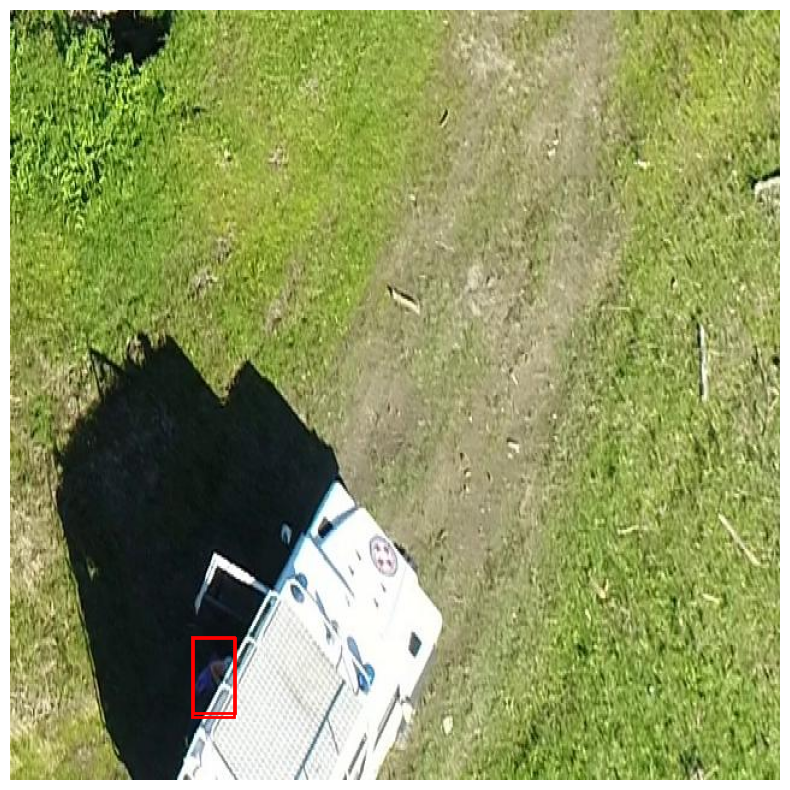

In [ ]:
test_image = os.path.join(IMAGES_PATH, 'valid', os.listdir(os.path.join(IMAGES_PATH, 'valid'))[0])
results_test = model.predict(test_image, conf=0.25)[0]
img = PILImage.open(test_image)
plt.figure(figsize=(10, 10))
plt.imshow(img)
ax = plt.gca()
for bbox in results_test.boxes.xyxy:
    x1, y1, x2, y2 = bbox[:4].cpu().numpy()
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                           edgecolor='red', facecolor='none')
    ax.add_patch(rect)
plt.axis("off")
plt.show()


WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /content/SARD/SARD/search-and-rescue-2/images/valid/gss1093_jpg.rf.84cb0e61b79cab2f202f93adebcbd813.jpg: 640x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /content/SARD/SARD/search-and-rescue-2/images/valid/gss1658_jpg.rf.4130bbf6427bfc64ff60c76e18875a4b.jpg: 640x640 3 Runnings, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /content/SARD/SARD/search-and-rescue-2/images/valid/gss1495_jpg.rf.b30ada643d64c788f4784de2343c55fa.jpg: 640x640 2 Runnings, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ Mod

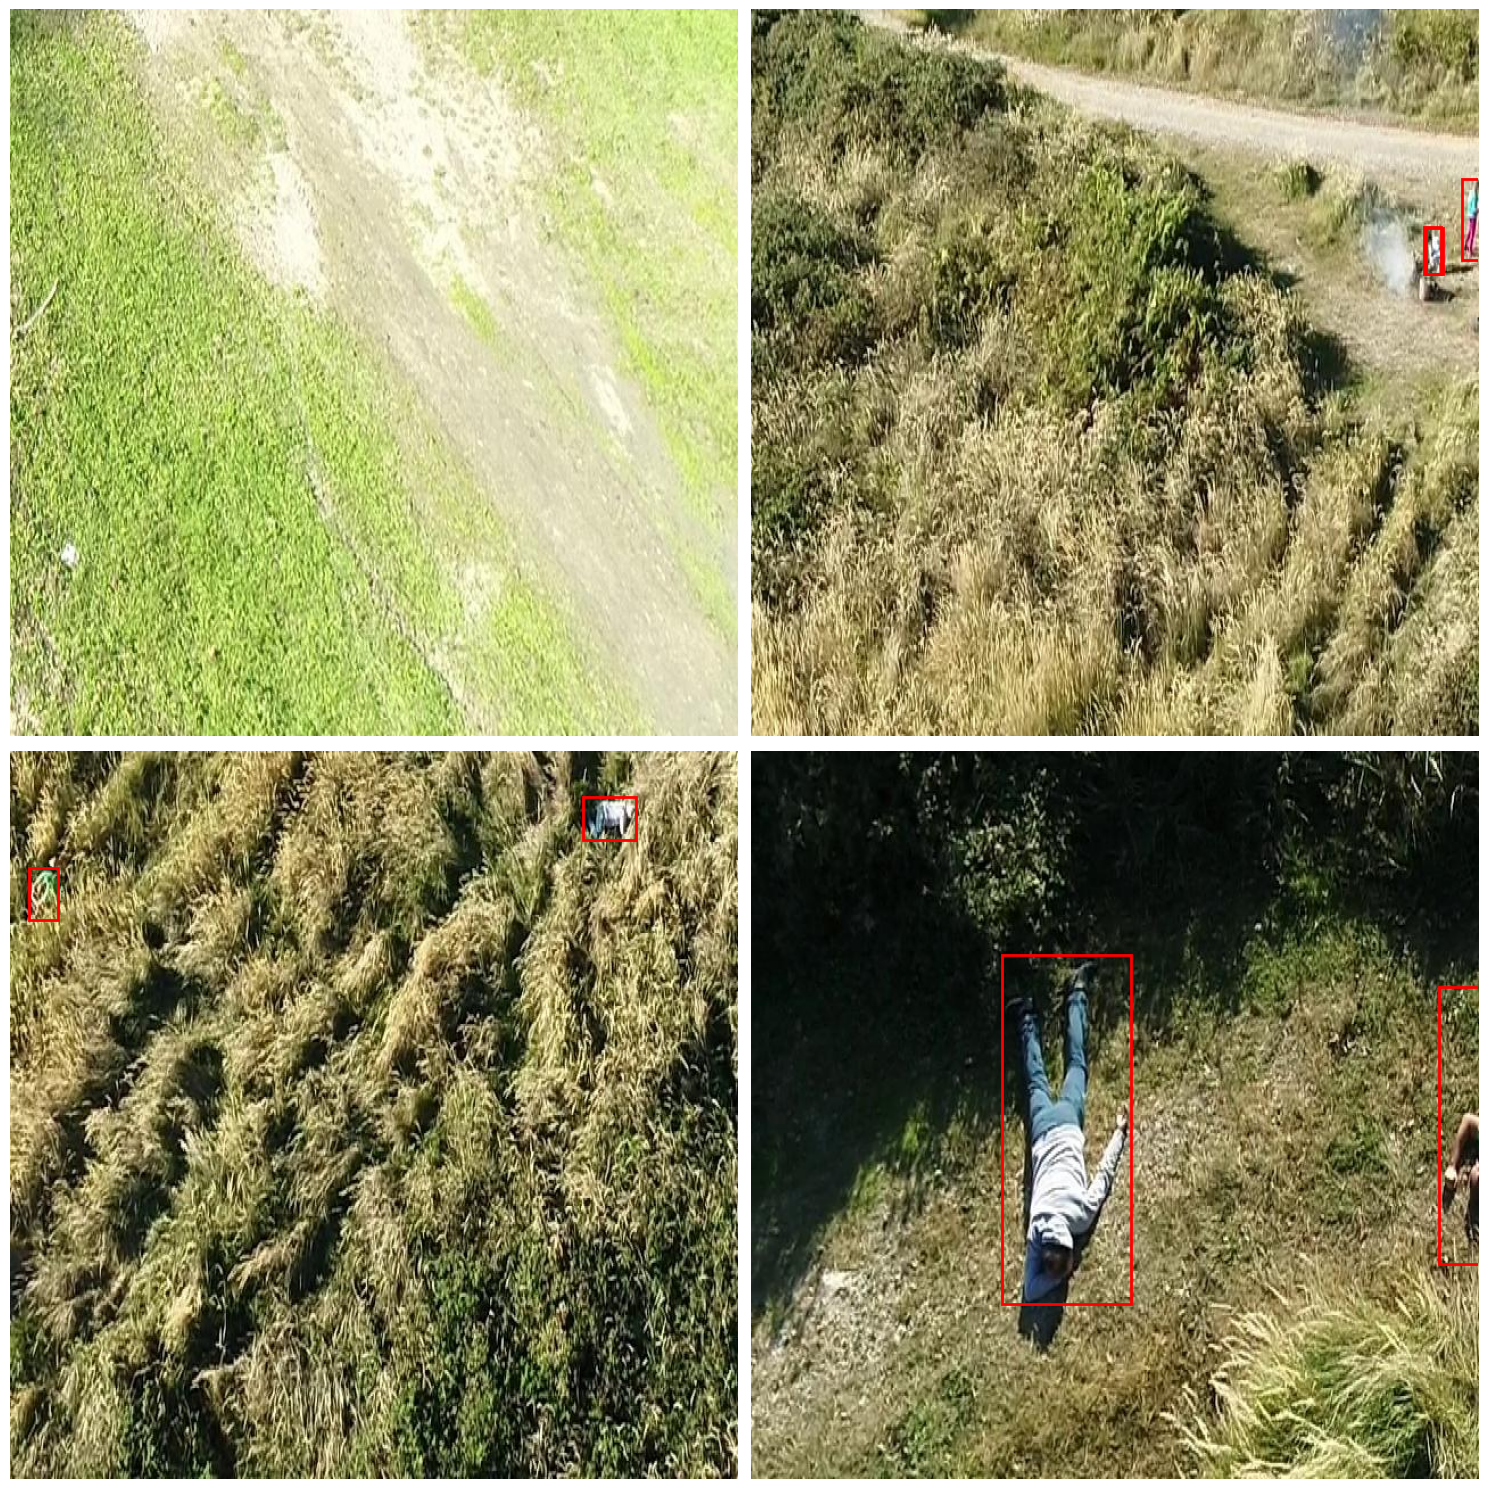

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image as PILImage

# Get all image filenames from the 'valid' folder
valid_dir = os.path.join(IMAGES_PATH, 'valid')
all_images = os.listdir(valid_dir)

# Randomly select 4 images
random_images = random.sample(all_images, 4)

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

# Loop over the 4 randomly selected images
for i, image_name in enumerate(random_images):
    image_path = os.path.join(valid_dir, image_name)

    # Run YOLOv8 prediction
    results_test = model.predict(image_path, conf=0.25)[0]

    # Open image
    img = PILImage.open(image_path)
    axs[i].imshow(img)
    axs[i].axis("off")

    # Draw bounding boxes
    for bbox in results_test.boxes.xyxy:
        x1, y1, x2, y2 = bbox[:4].cpu().numpy()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                 edgecolor='red', facecolor='none')
        axs[i].add_patch(rect)

plt.tight_layout()
plt.show()
